<a href="https://colab.research.google.com/github/CompPsychology/psych290_colab_public/blob/main/notebooks/week-05/W5_Tutorial_07_R_dataImport_metaTablePlots_(csv).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W5 Tutorial 7 -- Universal data wrangling tutorial: importing CSVs into the database, and plotting meta-table features (2025-03)

(c) Johannes Eichstaedt & the World Well-Being Project, 2023.

✋🏻✋🏻 NOTE - You need to create a copy of this notebook before you work through it. Click on "Save a copy in Drive" option in the File menu, and safe it to your Google Drive.

✉️🐞 If you find a bug/something doesn't work, please slack us a screenshot, or email johannes.courses@gmail.com.


This tutorial covers importing raw data in messy CSVs, cleaning them, to produce descriptives statistics and figures:
* messages over time
* messages per user (group)
* words per user (group)

💡 Sections 1) to 5) of this tutorial will be a little dull (sorry! data wrangling! gah!) but after that, we'll be plotting in R, and things will become fun again. Just bear with us!

## 1) Setting up Colab with DLATK and SQLite

In [ ]:
database = "tutorial_07"

### 1a) Install DLATK

In [ ]:
# installing DLATK and necessary packages
!git clone -b psych290 https://github.com/dlatk/dlatk.git
!pip install -r dlatk/install/requirements.txt
!pip install dlatk/
!pip install wordcloud langid jupysql

# used for sentence tokenization (later)
import nltk
nltk.download('punkt_tab')

Cloning into 'dlatk'...
remote: Enumerating objects: 6996, done.
remote: Counting objects: 100% (1168/1168), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 6996 (delta 1077), reused 1025 (delta 1009), pack-reused 5828 (from 1)
Receiving objects: 100% (6996/6996), 62.39 MiB | 13.69 MiB/s, done.
Resolving deltas: 100% (4948/4948), done.
Updating files: 100% (338/338), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 87.8 MB/s eta 0:00:00
  

Processing ./dlatk
  Preparing metadata (setup.py) ... done
  Created wheel for dlatk: filename=dlatk-1.3.1-py3-none-any.whl size=35635918 sha256=b9b84a235846364ae07d1373caabd87c0e1ef6d8c41f840d3d3eda79a66a94ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-kwm2voqc/wheels/cc/c9/65/e1ecc64bac68518c07b286fe86921aa938e11a0c3a87d8ff93
Successfully built dlatk
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.8/192.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 6.6 MB/s eta 0:00:00


### 1b) Download the data for this tutorial & custom R script

This github repo contains fresh copies of CSVs for `dla_tutorial` and also `tutorial_07` CSVs!

In [ ]:
# this download the csvs we need for this tutorial
!git clone https://github.com/CompPsychology/psych290_data.git

Cloning into 'psych290_data'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 30 (delta 3), reused 10 (delta 2), pack-reused 17 (from 1)
Receiving objects: 100% (30/30), 28.70 MiB | 18.65 MiB/s, done.
Resolving deltas: 100% (3/3), done.


Have a look on the left in the file browser, you see csv files in ./psych290_data/tutorial_07.


FYI, we will use `psych290RcodeV1.R` with custom DLATK-related functions to use in R. We copied it above, but if you ever need a copy (RStudio at home!), [you can download it here:  make a copy!](https://drive.google.com/drive/folders/1LnEKn7tyBiXLsuNl_SXkqljZFRUs9S4k?usp=sharing) ✅

### 1c) Setup database connection

In [ ]:
# loads the %%sql extension
%load_ext sql

# connects the extension to the database - mounts both databases as engines
from sqlalchemy import create_engine
tutorial_db_engine = create_engine(f"sqlite:///sqlite_data/{database}.db?charset=utf8mb4")
dlatk_lexica_engine = create_engine(f"sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4")

# attaches the dlatk_lexica.db so tutorial_db_engine can query both databases
from IPython import get_ipython
from sqlalchemy import event

# auto‑attach the lexica db whenever tutorial_db_engine connects
@event.listens_for(tutorial_db_engine, "connect")
def _attach_lexica(dbapi_conn, connection_record):
    dbapi_conn.execute("ATTACH DATABASE 'sqlite_data/dlatk_lexica.db' AS dlatk_lexica;")

%sql tutorial_db_engine

#set the output limit to 50
%config SqlMagic.displaylimit = 50

### 1d) (ONLY If nedded: SOFT RELOAD): If you have a **"database lock"** problem

If you face a "database locked" issue, restart the session (Runtime ==> Restart Session) & run this cell to get set back up!


In [ ]:
database = "tutorial_07"

%reload_ext sql

from sqlalchemy import create_engine
tutorial_db_engine = create_engine(f"sqlite:///sqlite_data/{database}.db?charset=utf8mb4")
dlatk_lexica_engine = create_engine(f"sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4")

# set the output limit to 50
%config SqlMagic.displaylimit = 50

from IPython import get_ipython
from sqlalchemy import event

# auto‑attach the lexica db whenever tutorial_db_engine connects
@event.listens_for(tutorial_db_engine, "connect")
def _attach_lexica(dbapi_conn, connection_record):
    dbapi_conn.execute("ATTACH DATABASE 'sqlite_data/dlatk_lexica.db' AS dlatk_lexica;")

%sql tutorial_db_engine

## 2) Setting up R

Like in the previous tutorials with `%%sql`, this time we will load another extension called `rpy2.ipython` that lets us use `%%R` (to run the R commands) in the same notebook.

🤯🤯 With this we can run SQL (`%%sql`), R (`%%R`), DLATK & shell commands (`!something`), as well as Python in the same notebook. It's gonna be less complicated than it sounds! 🤯🤯

In [ ]:
%load_ext rpy2.ipython

let's install and load R's dependencies:

In [ ]:
# this is equivalent to install.packages() but much faster!!

!apt-get update -qq

!apt-get install -y \
  r-cran-ggthemes \
  r-cran-reshape2 \
  r-cran-psych \
  r-cran-apatables \
  r-cran-rsqlite

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  r-cran-abind r-cran-arm r-cran-bh r-cran-car r-cran-cardata r-cran-coda
  r-cran-cowplot r-cran-deriv r-cran-doby r-cran-formula r-cran-gparotation
  r-cran-lavaan r-cran-lme4 r-cran-matrixmodels r-cran-mbess r-cran-mi
  r-cran-microbenchmark r-cran-minqa r-cran-mnormt r-cran-mvtnorm
  r-cran-nloptr r-cran-numderiv r-cran-openmx r-cran-pbivnorm r-cran-pbkrtest
  r-cran-plogr r-cran-plyr r-cran-quantreg r-cran-rbibutils r-cran-rcppeigen
  r-cran-rcppparallel r-cran-rdpack r-cran-reformulas r-cran-rpf r-cran-sem
  r-cran-semtools r-cran-sparsem r-cran-stanheaders
Suggested packages:
  r-cran-alr4 r-cran-coxme r-cran-effects r-cran-leaps r-cran-lmtest
  

In [ ]:
%%R

# load packages
library(tidyverse)
library(ggthemes)
library(reshape2)
library(psych)
library(apaTables)

#some options
options(repr.plot.width=20,repr.plot.height=10)

# and the custom R functions we have written to work with DLATK
source('./psych290_data/helper_files/psych290RcodeV1.R')

We can see that the packages are imported under **Attaching Packages** section of the output above. Ignore the **Conflicts** warnings. With the initial furniture moving done, let's begin reading a few custom CSV files into the R environment.

<h1>🤓<h1/>


Let's check what files we have in the tutorial data directory using the list `ls` command. This is a basic command line (shell) function. `*` is a wildcard, matching any number of any characters before a `.csv` file ending.

In [ ]:
!ls -lh psych290_data/tutorial_07/*.csv

-rw-r--r-- 1 root root 45K May  1 04:11 psych290_data/tutorial_07/Tutorial_07_data_lexica.csv
-rw-r--r-- 1 root root 39M May  1 04:11 psych290_data/tutorial_07/Tutorial_07_data_msgs.csv
-rw-r--r-- 1 root root 41K May  1 04:11 psych290_data/tutorial_07/Tutorial_07_data_outcomes.csv


Now that we have seen the CSV files, let's read one of them `Tutorial_07_data_msgs.csv` into a R dataframe.

Obviously, you can also just do clicky clicky on the left in the file browser and see them. Arguably that's easier.

## 3) Importing your message table (from CSV) <a class="anchor" id="import_msg"></a>

To import the files into R, we use `read.csv` provided by native R (and not the `read_csv` in `dplyr`) because it provides a helpful parameter `encoding` to specify the text-encoding.

Since we'll deal with social media data quite often there's a very high chance that we would see a lot of bizzare tokens like emoticons, characters from non-English languages, etc, and the encoding varies with your system.

That said, let's read the files now.

Btw, if you navigate your file in the file viewer on the left, you can right-click on the file and select `Copy path` 🚀 -- for when you write these cells yourself.

In [ ]:
%%R

# If you uploaded your data from a Windows machine, use the below command
# tt7_msgs <- read.csv('psych290_data/tutorial_07/Tutorial_07_data_msgs.csv', encoding="Windows-1252")

# Mac/Linux-generated CSV file
tt7_msgs <- read.csv('psych290_data/tutorial_07/Tutorial_07_data_msgs.csv', encoding="UTF-8")

Let's do a sanity check and see the first few rows of the file.

The standard way to do this would be to use the head() function within a `%%R` cell -- but the output looks hard to read.

In [ ]:
%%R head(tt7_msgs)

   person when.it.was.written
1 2214588          2003-10-31
2 2214588          2003-11-30
3 2214588          2003-11-28
4 2214588          2003-11-28
5 2214588          2003-11-28
6 2214588          2003-11-27
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

If we run this through line-magic (`%R` with just one %) the output will get formatted better because colab can use more Python magic.

In [ ]:
%R head(tt7_msgs)

,person,when.it.was.written,this_is_totally_my_message_text
1,2214588,2003-10-31,"I have always had a great love of science, the..."
2,2214588,2003-11-30,"""So crank it up, push it out, bust it up, and ..."
3,2214588,2003-11-28,Fucking blogger god damn you...where did you s...
4,2214588,2003-11-28,"I watched amelie tonight for the first time, a..."
5,2214588,2003-11-28,When did everything lose its meaning...when di...
6,2214588,2003-11-27,"I went to the racebannon show tonight, and Chu..."


---

💡 To summarize: if you have some table, you can do `%R table` (aka a line-magic) instead of `%%R table` (aka a cell-magic) to display the output in this nicer way. It uses Python's `pandas` under the hood.

---

Now that we have loaded the data alright, let's use a custom R function johannes has written to check the dataframe (`checkDf`, `checkDf2`, `checkDf3` serve this purpose, which provide increasingly more mind-numbing details).

In [ ]:
%%R

checkDf2(tt7_msgs)

                            names NAs numeric   min     max zeroes nonNA unique
1                          person   0       1 11253 4333855      0 33278   1000
2             when.it.was.written   0       0                                  
3 this_is_totally_my_message_text   0       0                                  


So here is what this looks like in pretty (also to pratice what we just learned):

In [ ]:
%R checkDf2(tt7_msgs)

,names,NAs,numeric,min,max,zeroes,nonNA,unique
1,person,0,1,11253,4333855,0,33278,1000
2,when.it.was.written,0,0,,,,,
3,this_is_totally_my_message_text,0,0,,,,,


ah ok. so this file is a mess, for DLATK purposes at least, and the column names are terrible. Let's make the columns something reasonable.

<h2>⚠️<h2/>

Remember that DLATK needs message tables to have a `message` and a `message_id` column. Let's fix the message column name.

<h2>⚠️<h2/>



In [ ]:
%%R

colnames(tt7_msgs) <- c("user_id", "created_date", "message")
colnames(tt7_msgs)

[1] "user_id"      "created_date" "message"     


now we need to add the `message_id` column -- let's just use integer from 1 to the length of the data frame -- `dim(tt7_msgs)[1]` will give us the number of rows.

In [ ]:
%%R

dim(tt7_msgs)[1]

[1] 33278


so let's use that to make the message_id's.

In [ ]:
%%R

tt7_msgs$message_id <- 1:dim(tt7_msgs)[1]

let's check out our resulting table by looking at the top rows, and by running `checkDf2()`.

In [ ]:
%R head(tt7_msgs)

,user_id,created_date,message,message_id
1,2214588,2003-10-31,"I have always had a great love of science, the...",1
2,2214588,2003-11-30,"""So crank it up, push it out, bust it up, and ...",2
3,2214588,2003-11-28,Fucking blogger god damn you...where did you s...,3
4,2214588,2003-11-28,"I watched amelie tonight for the first time, a...",4
5,2214588,2003-11-28,When did everything lose its meaning...when di...,5
6,2214588,2003-11-27,"I went to the racebannon show tonight, and Chu...",6


In [ ]:
%R checkDf2(tt7_msgs)

,names,NAs,numeric,min,max,zeroes,nonNA,unique
1,user_id,0,1,11253,4333855,0,33278,1000
2,created_date,0,0,,,,,
3,message,0,0,,,,,
4,message_id,0,1,1,33278,0,33278,33278


Both look good. let's write them to your `tutorial_07` database.

### 3a) Writing to database <a class="anchor" id="write_db"></a>

First we need to open a database connection that the SQLite package can work with. The `-i database_path` imports that variable from Python!

**NOTE:** Remember the `UTF-8` encoding mentioned earlier? Now that we have read the files with that encoding, we need to tell SQLite about it. We do that in the cell below. It makes sure emojis survive, etc.

In [ ]:
# constructs the pathname
database_path = f"sqlite_data/{database}.db"
database_path

'sqlite_data/tutorial_07.db'

In [ ]:
%%R -i database_path

# load DBI for generic database functions and RSQLite as the SQLite backend
library(DBI)
library(RSQLite)

# connects to a file-based sqlite DB
db_con <- dbConnect(RSQLite::SQLite(),
                    dbname = database_path)

# enforce UTF-8 encoding
dbExecute(db_con, "PRAGMA encoding = 'UTF-8';")

# this attaches the dlatk_lexica database
dbExecute(db_con, "ATTACH DATABASE 'sqlite_data/dlatk_lexica.db' AS dlatk_lexica;")

[1] 0


---
In MySQL, it's done like this:

🐬🐬🐬

```
%%R -i database

db_con = dbConnect(MySQL(),
                   user=SUNET,
                   password="",
                   dbname=database,
                   host='localhost',
                   encoding='UTF-8')

dbSendQuery(db_con, "SET NAMES utf8mb4;")
dbSendQuery(db_con, "SET CHARACTER SET utf8mb4;")
dbSendQuery(db_con, "SET character_set_connection=utf8mb4;")
```


In MySQL, it would have now opened a new database connection, that assumes that the MySQL server is listening on default port `3306` on the localhost (either a server or your own machine, depending on where you'd be running this notebook).

---

Alright, let's write the new message table to the database with `dbWriteTable()`.

`dbWriteTable()` expects: the database connection object `db_con`, the name we want to give our new table, the data to write ther,, and then some optional parameters -- such as the request to overwrite data if it exists, and not to include row names (in this case, just the numbers 1 to whatever).

**NOTE:** Don't forget `UTF-8`!!


In [ ]:
%%R

dbWriteTable(db_con,
             "tt7_msgs",
             tt7_msgs,
             overwrite=TRUE,
             row.names=FALSE,
             encoding="UTF-8")

After we write this table, let's check for it in SQLite.


In [ ]:
%sql PRAGMA table_list

Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

schema,name,type,ncol,wr,strict
main,tt7_msgs,table,4,0,0
main,sqlite_schema,table,5,0,0
temp,sqlite_temp_schema,table,5,0,0
dlatk_lexica,nrc_sent,table,4,0,0
dlatk_lexica,sqlite_schema,table,5,0,0
dlatk_lexica,sqlite_sequence,table,2,0,0
dlatk_lexica,fb2000_cp,table,4,0,0
dlatk_lexica,fb2000_freq_t50ll,table,4,0,0
dlatk_lexica,dd_permaV3,table,4,0,0
dlatk_lexica,dd_emnlp14_ageGender,table,4,0,0


You see the new `tt7_msgs` table at the top.

This is SQL output. To get SQLlite output into R, we use the `dbGetQuery` command. For example, this pulls the same output into R (and then just outputs it).

In [ ]:
%%R

dbGetQuery(db_con, "PRAGMA table_list")

         schema                 name  type ncol wr strict
1          main             tt7_msgs table    4  0      0
2          main        sqlite_schema table    5  0      0
3          temp   sqlite_temp_schema table    5  0      0
4  dlatk_lexica             nrc_sent table    4  0      0
5  dlatk_lexica        sqlite_schema table    5  0      0
6  dlatk_lexica      sqlite_sequence table    2  0      0
7  dlatk_lexica            fb2000_cp table    4  0      0
8  dlatk_lexica    fb2000_freq_t50ll table    4  0      0
9  dlatk_lexica           dd_permaV3 table    4  0      0
10 dlatk_lexica dd_emnlp14_ageGender table    4  0      0
11 dlatk_lexica        dd_PastPreFut table    4  0      0
12 dlatk_lexica dd_wassa16_affectInt table    4  0      0
13 dlatk_lexica             nrc_emot table    4  0      0


### 3b) Inspecting the written table <a class="anchor" id="inspect"></a>

Let's confirm if it's written alright by listing 5 random rows. But how do we do that - using good old `%%sql`!

First thing, let's use the right database, i.e; `tutorial_07`.

 To switch databses in SQLite you run:
 * `%sql tutorial_db_engine` or

 * `%sql dlatk_lexica_engine`!

This is like 🐬🐬🐬 `USE` in MySQL.

(FYI, we ran the command below to create a connection to the tutorial sqlite database file:)
```
tutorial_db_engine = create_engine(f"sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4")
```


In [ ]:
%sql tutorial_db_engine

...which is the same as ```🐬🐬🐬 %sql USE {database};🐬🐬🐬```

Now that we've changed databases, pull 5 random messages:

In [ ]:
%%sql

SELECT *
FROM tt7_msgs
ORDER BY RANDOM()
LIMIT 5;

Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

user_id,created_date,message,message_id
3645176,2004-06-15,"June 16, 2004 The Honorable Arnold Schwarzenegger Governor of the State of California State Capitol Building Sacramento, California 95814 Dear Governor Schwarzenegger, I noticed today that SB 1160 (a bill that would allow illegal immigrants to receive California driversâ licenses) is moving its way through the state Legislature. I am not writing to tell you the reasons why it should not become law, but rather why you cannot let it become law. Last year many Californians, myself included, recalled Gray Davis and elected you to keep illegal immigrants from receiving driversâ licenses and to repeal the car registration tax increase. We did not elect you to expressed reservations about parts of such a bill, or to work to find common ground, but to kill itâ¦and you know this. I was happy when you made good on your promise to repeal the mistakes made by Gray Davis; I think we all were. However, now that SB 1160 is in the news and apparently working its way towards your desk, Iâm getting worried. You need to make a stand, publicly, against SB 1160, in any form or any bill like it. I like you and I will stick with you if you stand strong against this attempt to harm our state. Simply put, if California grants driversâ licenses to illegal immigrants then someone else will be our next governor. Sincerely, Daniel E. Smith",16366
3229995,2004-05-20,"In the June 2004 Cleo (on sale now) there is an article on stalking. The only reason this is of note is becuase they list the Beckhams as reportedly being the most stalked couple in the world. When you think about it this is a fairly accurate and terribly frightening statistic. There have been at least three kidnap attempts on the lives of Victoria, Brooklyn and Romeo and a number of death threats for the couple. Why? What is the reason for all these threats on their lives? Personally, I think it has something to do with David's constant acknowledgement that he would do anything to protect his wife and children. I draw this conclusion from the fact that it is never David that they want to kidnap, but rather it is to him that they address any demands (I read somewhere - can't remember where - that one of the kidnappers were going to ask for millions of pounds to let them go). It is a money making scheme which unfortunately puts the people he loves most in the world in danger - what man wouldn't pay?",12605
756402,2003-01-12,Let it be known that Drew and Sam stole Bumper Waltzing from Lynzi and myself :),25999
3543301,2004-08-01,that only gay men get divas?? whatever. mine is urlLink mariah .,22382
3873347,2004-07-17,"Speedy and I took our training up to Golden Gate Park today to do our long run for the weekend. It was definitely going to be an experience. I had only been through the park once and that was on a bike, so I wasn't quite sure what the terrain was going to be but I figured we could handle whatever was thrown at us. The schedule was for a 65 minute run and I was sure we weren't going to find the exit of the park before we turned around. Results: 6.127 miles in 1 hour, 5:19 minutes. Don't really have a breakdown today but I did calculate it out to a 10:39 pace for the whole thing. Not a bad showing considering the long hills that we encountered through the course. I was very happy with our time overall. I definitely at the end had enough to go a little futher, though we did have a very slow portion about 2 miles into the race so that we could recover from one of the longest hills. All in all very nice, and it was nice to get off of the streets of Los Altos for a day. Still have our 30 minute run tomorrow and we will probably take that over to Stanford's campus, just to get a little change of scenery again before another tough week ahead. Keep on running all, FX",22587


Ok, nice. Let's check on how the table is set up:

In [ ]:
%%sql

PRAGMA table_info(tt7_msgs);

Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

cid,name,type,notnull,dflt_value,pk
0,user_id,INTEGER,0,None,0
1,created_date,TEXT,0,None,0
2,message,TEXT,0,None,0
3,message_id,INTEGER,0,None,0


```🐬🐬🐬describe tt7_msgs;🐬🐬🐬```

<h3>FYI - 🐬🐬🐬<h3/>

In MySQL world: `dbWriteTable()` defaults to the `TEXT` datatype by default to store a text column, that can accomodate 65,535 (roughly 64KB) characters. This is too short when we have datasets with longer messages, eg, Facebook posts, Books, etc. If we had MySQL, we would need to set the datatype differently on import:


```
%%R
dbWriteTable(
    db_con,
    "tt7_msgs",
    tt7_msgs,
    overwrite=TRUE,
    row.names=FALSE,
    field.types= c(created_date='DATETIME', message='LONGTEXT'),
    encoding="UTF-8")
```
🐬🐬🐬

We can still use it in SQLlite world, to force a particular column encoding. ⚠️ In `field.types`, you need only include columns that you want to be assigned a specific type. The other columns will be detected automatically!


Fortunately for once, this is not (for once) a problem in SQLite, and we can just encode long text simply as `TEXT.` Great!

---

### 3c) Create indices

Ok, let's add indices to the `user_id` and `message_id` columns.

In [ ]:
%%sql

CREATE INDEX idx_tt7_msgs_user_id ON tt7_msgs (user_id);
CREATE INDEX idx_tt7_msgs_message_id ON tt7_msgs (message_id);

Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

++
||
++
++

Great! Now we are ready to roll with the table in DLATK. Before we do that, let's do the same thing for the outcome table.

#### Do you want to split your messages by sentences?

**Note:** In some cases, we want to to split our documents (`messages`) into sentences, say because they are quite long, and we would prefer to have a larger number of shorter messages (so here: sentences, rather than sets of sentences).

This may be particularly useful for better **topic modeling**, during which it is better if we have **more shorter messages** than fewer longer ones. If you'd like to transform your message table like this, look just at the end of the tutorial.

## 4) Importing your outcome table (from CSV) <a class="anchor" id="import_outcome"></a>

Once you've cloned (downloaded) them from github (or uploaded them to colab), import them with R. You can see in filesystem on the left.

In [ ]:
%%R

# If you uploaded your data from a Windows machine, use the below command
# tt7_outcomes <- read.csv('./psych290_data/tutorial_07/Tutorial_07_data_outcomes.csv', encoding="Windows-1252")

# mac/linux encoding:
tt7_outcomes <- read.csv('./psych290_data/tutorial_07/Tutorial_07_data_outcomes.csv', encoding='UTF-8')

Like we did with the message table, let's do a sanity check and check the first few rows of the file.

In [ ]:
%R head(tt7_outcomes)

,person,gender,how_old_they_are,whatTheyDoForWork,ascending_sun_sign,is_female
1,4316235,female,24,Accounting,Taurus,1
2,3483306,male,23,Manufacturing,Gemini,0
3,3905703,female,16,Student,Capricorn,1
4,3409695,male,23,Student,Gemini,0
5,4101122,female,17,indUnk,Capricorn,1
6,3767498,male,26,indUnk,Aries,0


Column names are a mess again. Let's run some basic diagnostics, then fix them.

In [ ]:
%R checkDf2(tt7_outcomes)

,names,NAs,numeric,min,max,zeroes,nonNA,unique
1,person,0,1,11253,4333855,0,1000,1000
2,gender,0,0,,,,,
3,how_old_they_are,0,1,13,48,0,1000,26
4,whatTheyDoForWork,0,0,,,,,
5,ascending_sun_sign,0,0,,,,,
6,is_female,0,1,0,1,502,1000,2


The read_csv output says that there are 1000 rows, and `checkDf2()` gives us more details -- of 6 columns are 3 numeric and 3 are not.

In [ ]:
%%R

colnames(tt7_outcomes)

[1] "person"             "gender"             "how_old_they_are"  
[4] "whatTheyDoForWork"  "ascending_sun_sign" "is_female"         


Let's clean this up.

<h1>⚠️<h1/>

Careful to make sure that person-identifiers are in the column that has the same name as we've picked in the message table. That will be our `--correl_field` in DLATK -- they have to line up. here, let's choose `user_id`.

In [ ]:
%%R

colnames(tt7_outcomes) <- c("user_id", "gender", "age", "occu", "sign", "is_female")
head(tt7_outcomes)

  user_id gender age          occu      sign is_female
1 4316235 female  24    Accounting    Taurus         1
2 3483306   male  23 Manufacturing    Gemini         0
3 3905703 female  16       Student Capricorn         1
4 3409695   male  23       Student    Gemini         0
5 4101122 female  17        indUnk Capricorn         1
6 3767498   male  26        indUnk     Aries         0


Looks good. Let's write that to the database, into a table called `tt7_outcomes`.


Remember, `dbWriteTable()` wants the connection object (db_con), then name of the table it's writing to, then then R dataframe it's writing from, and then some additional flags (always overwrite, don't write the dufus R rownames to the database, etc.)

In [ ]:
%%R

dbWriteTable(db_con,
             "tt7_outcomes",
             tt7_outcomes,
             overwrite=TRUE,
             row.names=FALSE,
             encoding="UTF-8")

### 4a) Inspect the table

In [ ]:
%%sql

PRAGMA table_info(tt7_outcomes);

Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

cid,name,type,notnull,dflt_value,pk
0,user_id,INTEGER,0,None,0
1,gender,TEXT,0,None,0
2,age,INTEGER,0,None,0
3,occu,TEXT,0,None,0
4,sign,TEXT,0,None,0
5,is_female,INTEGER,0,None,0


```🐬🐬🐬 describe tt7_outcomes; 🐬🐬🐬```

### 4b) Create indices

Best to add an index on user_id and other columns you may be filtering or grouping by (in this case, occu)!

In [ ]:
%%sql

CREATE INDEX idx_tt7_outcomes_user_id ON tt7_outcomes (user_id);
CREATE INDEX idx_tt7_outcomes_occu ON tt7_outcomes (occu);

Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

++
||
++
++

looks good!!

## 5) Importing a custom lexicon table (from CSV) <a class="anchor" id="import_dict"></a>

In the third step, we'll show you how to work with your own lexica. For demonstration, we'll use a modified version of the `mini_LIWC2015` that you have used already.

Similar to the message table, DLATK expects lexicon tables in a certain format. The tables must have columsn names:

* `id` - unique identifier of the rows in the table.
* `term` - tokens in the lexicon.
* `category` - identifies the particular dictionary "category" that the token belongs to (e.g., "POSEMO" for LIWC's positive emotion dict).
* `weight` - weights (if a weighted lexicon like `labmt`) or (all = 1 if unweighted like `LIWC`).

in that order. Once we upload a CSV which contain such columns (or at least similar) we import the uploaded lexica into R, and update them like we did with the other tables above.

In [ ]:
%%R

# If you uploaded your data from a Windows machine, use the below command
# tt7_lexica <- read.csv('./psych290_data/tutorial_07/Tutorial_07_data_lexica.csv', encoding="Windows-1252")

# Linux/mac encoding
tt7_lexica <- read.csv('./psych290_data/tutorial_07/Tutorial_07_data_lexica.csv', encoding='UTF-8')

sanity check -

In [ ]:
%R head(tt7_lexica)

,X,tokens,dictionary,weights
1,0,(:,POSEMO,1
2,1,:),POSEMO,1
3,2,accept,POSEMO,1
4,3,accepta*,POSEMO,1
5,4,accepted,POSEMO,1
6,5,accepting,POSEMO,1


In [ ]:
%R checkDf2(tt7_lexica)

,names,NAs,numeric,min,max,zeroes,nonNA,unique
1,X,0,1,0,2123,1,2124,2124
2,tokens,0,0,,,,,
3,dictionary,0,0,,,,,
4,weights,0,1,1,1,0,2124,1


We see that the columns are not named as expected by DLATK (see above: id, term, category, weight). So we rename them here.

In [ ]:
%%R

colnames(tt7_lexica) <- c("id", "term", "category", "weight")
head(tt7_lexica)

  id      term category weight
1  0        (:   POSEMO      1
2  1        :)   POSEMO      1
3  2    accept   POSEMO      1
4  3  accepta*   POSEMO      1
5  4  accepted   POSEMO      1
6  5 accepting   POSEMO      1


And finally, write them to your database.

**Note:** Normally, DLATK expects all dictionaries in `dlatk_lexica`. But you can also store lexica in another database -- e.g., where your message table is -- you just need to tell DLATK.

E.g., when you extract your own lexicon (from 1grams) in the future with `--add_lex_table -l your_lexicon`, you will have to add the flag `--lexicondb your_database` (which is probably your tutorial or project database).

For now, let's write the new dictionary to the tutorial database.

In [ ]:
%%R

dbWriteTable(db_con,
             "tt7_lexica",
             tt7_lexica,
             overwrite=TRUE,
             row.names=FALSE,
             encoding="UTF-8")

In [ ]:
%sql PRAGMA table_info(tt7_lexica);

Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

cid,name,type,notnull,dflt_value,pk
0,id,INTEGER,0,None,0
1,term,TEXT,0,None,0
2,category,TEXT,0,None,0
3,weight,INTEGER,0,None,0


### 5a) Create indices

In [ ]:
%%sql

CREATE INDEX idx_tt7_lexica_term ON tt7_lexica (term);
CREATE INDEX idx_tt7_lexica_category ON tt7_lexica (category);

Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

++
||
++
++

## 6) Extract a 1gram table with DLATK! <a class="anchor" id="1gram_xtract"></a>

Let's extract the 1-gram features from the `tt7_msgs` table now using DLATK. This takes 2 minutes. You can see the progress in the output.

In [ ]:
database = 'tutorial_07'
msgs_table = 'tt7_msgs'

In [ ]:
!dlatkInterface.py \
  --corpdb {database} \
  --corptable {msgs_table} \
  --correl_field user_id \
  --add_ngrams -n 1



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2025-05-01 04:46:24
-----
Connecting to SQLite database: /content/sqlite_data/tutorial_07
query: PRAGMA table_info(tt7_msgs)
SQL Query: DROP TABLE IF EXISTS feat$1gram$tt7_msgs$user_id
SQL Query: CREATE TABLE feat$1gram$tt7_msgs$user_id ( id INTEGER PRIMARY KEY, group_id INTEGER, feat VARCHAR(36), value INTEGER, group_norm DOUBLE)


Creating index correl_field on table:feat$1gram$tt7_msgs$user_id, column:group_id 


SQL Query: CREATE INDEX correl_field$1gram$tt7_msgs$user_id ON feat$1gram$tt7_msgs$user_id (group_id)


Creating index feature on table:feat$1gram$tt7_msgs$user_id, column:feat 


SQL Query: CREATE INDEX feature$1gram$tt7_msgs$user_id ON feat$1gram$tt7_msgs$user_id (feat)
query: PRAGMA table_info(tt7_msgs)
SQL Query: DROP TABLE IF EXISTS feat$meta_1gram$tt7_msgs$user_id
SQL Query: CREATE TABLE feat$meta_1gram$tt7_msgs$user_id ( id INTEGER PRIMARY KEY, group_id INTEG

Let's look at the tables that were created.

In [ ]:
%sqlcmd tables

Name
feat$1gram$tt7_msgs$user_id
feat$meta_1gram$tt7_msgs$user_id
tt7_lexica
tt7_msgs
tt7_outcomes


## 7) Merge the meta table features onto the outcome table! <a class="anchor" id="merge_feat_out"></a>

Let's pull the meta feat table into R, and make it "wide" with the `importFeat()` function.

In [ ]:
%%R

feat_meta <- dbGetQuery(db_con, "select * from `feat$meta_1gram$tt7_msgs$user_id`")

Let's look at what we just imported.

In [ ]:
%%R

checkDf2(feat_meta)

       names NAs numeric   min     max zeroes nonNA unique
1         id   0       1     1    4000      0  4000   4000
2   group_id   0       1 11253 4333855      0  4000   1000
3       feat   0       0                                  
4      value   0       1     1  492270      0  4000   2937
5 group_norm   0       1     1  492270      0  4000   2937


oh yes, a feature table. Let's convert into "wide format" with `importFeat()`. Let's use double line-magic so it looks pretty!

In [ ]:
%R feat_meta_wide <- importFeat(feat_meta)
%R checkDf2(feat_meta_wide)

In addition: Warning message:
call dbDisconnect() when finished working with a connection 


,names,NAs,numeric,min,max,zeroes,nonNA,unique
1,group_id,0,1,11253,4333855,0,1000,1000
2,_avg1gramLength,0,1,1.8997668997669,5.90291262135922,0,1000,998
3,_avg1gramsPerMsg,0,1,18.9444444444444,7708,0,1000,961
4,_total1grams,0,1,103,492270,0,1000,919
5,_totalMsgs,0,1,1,1308,0,1000,141


In [ ]:
%R head(feat_meta_wide)

,group_id,_avg1gramLength,_avg1gramsPerMsg,_total1grams,_totalMsgs
1,11253,3.635071,150.714286,1055.0,7.0
2,47519,3.816282,94.861446,15747.0,166.0
3,105748,3.720299,115.890383,112066.0,967.0
4,118791,3.863289,120.764706,6159.0,51.0
5,171019,3.667635,299.216152,125970.0,421.0
6,182779,3.751758,203.142857,1422.0,7.0


**So this is great** -- every row is a user now, and they just have their meta-data in columns. This is how your normal R dataframes are set up.

let's merge these columns onto our outcome table, which we'll push fresh from the DB. Note that we have to match `user_id` to `group_id`.

Let's make sure we keep all rows from the outcome table (...`all.x = TRUE`), in inspect our merge with `checkDf2()`.

In [ ]:
%%R
# this pulls the outcome table from the DB
outcomes <- dbGetQuery(db_con, "select * from tt7_outcomes")

# this merges the outcome table onto the meta-data table.
OF <- merge(outcomes, feat_meta_wide, by.x = "user_id", by.y = "group_id", all.x = TRUE)

# this inspects the merged table
checkDf2(OF)

              names NAs numeric              min              max zeroes nonNA
1           user_id   0       1            11253          4333855      0  1000
2            gender   0       0                                               
3               age   0       1               13               48      0  1000
4              occu   0       0                                               
5              sign   0       0                                               
6         is_female   0       1                0                1    502  1000
7   _avg1gramLength   0       1  1.8997668997669 5.90291262135922      0  1000
8  _avg1gramsPerMsg   0       1 18.9444444444444             7708      0  1000
9      _total1grams   0       1              103           492270      0  1000
10       _totalMsgs   0       1                1             1308      0  1000
   unique
1    1000
2        
3      26
4        
5        
6       2
7     998
8     961
9     919
10    141


Let's take a quick look!

In [ ]:
%R head(OF)

,user_id,gender,age,occu,sign,is_female,_avg1gramLength,_avg1gramsPerMsg,_total1grams,_totalMsgs
1,11253,male,26,Technology,Aquarius,0,3.635071,150.714286,1055.0,7.0
2,47519,male,23,Communications-Media,Sagittarius,0,3.816282,94.861446,15747.0,166.0
3,105748,female,26,Student,Scorpio,1,3.720299,115.890383,112066.0,967.0
4,118791,male,33,Internet,Virgo,0,3.863289,120.764706,6159.0,51.0
5,171019,female,23,Education,Leo,1,3.667635,299.216152,125970.0,421.0
6,182779,female,27,Internet,Sagittarius,1,3.751758,203.142857,1422.0,7.0


Let's write this table to database, and clean it up.

In [ ]:
%%R

dbWriteTable(db_con, "outcomes_meta", OF, overwrite=TRUE, row.names=FALSE, encoding='UTF-8')

Check that the columns are correct.

In [ ]:
%%sql

PRAGMA table_info(outcomes_meta);

Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

cid,name,type,notnull,dflt_value,pk
0,user_id,INTEGER,0,None,0
1,gender,TEXT,0,None,0
2,age,INTEGER,0,None,0
3,occu,TEXT,0,None,0
4,sign,TEXT,0,None,0
5,is_female,INTEGER,0,None,0
6,_avg1gramLength,REAL,0,None,0
7,_avg1gramsPerMsg,REAL,0,None,0
8,_total1grams,REAL,0,None,0
9,_totalMsgs,REAL,0,None,0


And add indexes (because it's a new table!)

In [ ]:
%%sql

CREATE INDEX idx_outcomes_meta_user_id ON outcomes_meta (user_id);
CREATE INDEX idx_outcomes_meta_occu ON outcomes_meta (occu);

Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

++
||
++
++

## 8) Create outcomes and message tables for users with GFT > 500 (say) <a class="anchor" id="gft"></a>

Let's make an outcome table (and then message table) that only contain those users who have written at least 500 words -- that will make it easy to make sure we are reporting statistics for the same users in R as DLATK is using when the group_freq thresh is set to 500.

In other words, we are setting up our "final study data set" for which to report statistics come publication time.

Let's see how many users we have that meet a group_freq_thresh (tokens per user) threshold of 500. Note that this is for user-level analyses -- in message level analyses, you might want to include all messages / groups. Then you don't need this step.

In [ ]:
%%sql

SELECT COUNT(*)
FROM outcomes_meta
WHERE _total1grams > 500;

Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

COUNT(*)
962


ok, 962! let's make an outcome table only containing these users, and a message table only containing their messages.  

In [ ]:
%%sql

DROP TABLE IF EXISTS outcomes_meta_n962;

CREATE TABLE outcomes_meta_n962 AS SELECT * FROM outcomes_meta WHERE _total1grams > 500;

Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

++
||
++
++

In MySQL

```
🐬🐬🐬
DROP TABLE IF EXISTS outcomes_meta_n962;
CREATE TABLE outcomes_meta_n962 like outcomes_meta;
INSERT INTO outcomes_meta_n962 SELECT * FROM outcomes_meta WHERE _total1grams > 500;
🐬🐬🐬
```

Let's make a message table that is subset to only these users, using a where (implicit, inner) join:

In [ ]:
%%sql

DROP TABLE IF EXISTS tt7_msgs_n962;

CREATE TABLE tt7_msgs_n962 AS
    SELECT a.*
    FROM tt7_msgs AS a, outcomes_meta_n962 AS b
    WHERE a.user_id = b.user_id;


Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

++
||
++
++

We'll also do this to the outcomes table (not the one merged with meta).

In [ ]:
%%sql

DROP TABLE IF EXISTS tt7_outcomes_n962;

CREATE TABLE tt7_outcomes_n962 AS
    SELECT a.*
    FROM tt7_outcomes AS a, outcomes_meta_n962 AS b
    WHERE a.user_id = b.user_id;

Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

++
||
++
++

Let's see if we have all the users in the new table.

In [ ]:
%%sql

SELECT COUNT(*)
FROM tt7_outcomes_n962;

Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

COUNT(*)
962


For comparison, the original message table had how many rows/messages?

In [ ]:
%%sql

SELECT COUNT(*)
FROM tt7_msgs;

Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

COUNT(*)
33278


And the new table?

In [ ]:
%%sql

SELECT COUNT(*)
FROM tt7_msgs_n962;

Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

COUNT(*)
33134


So we only lost 33,278 - 33,134 = 144 messages, or less than 1%. That's the thing with people who don't have a lot of words ... they don't tend to write a lot.

## 9) Plot message counts over time <a class="anchor" id="plot_msgs"></a>

Let's remind ourselves what's in the message table.

In [ ]:
%%sql

PRAGMA table_info(tt7_msgs_n962);

Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

cid,name,type,notnull,dflt_value,pk
0,user_id,INT,0,None,0
1,created_date,TEXT,0,None,0
2,message,TEXT,0,None,0
3,message_id,INT,0,None,0


Let's get simple counts by dates. Counting should always be done in SQL.

In [ ]:
%%R

messages.byDate <- dbGetQuery(
    db_con,
    "SELECT COUNT(*) AS message_count, DATE(created_date) AS date FROM tt7_msgs_n962 GROUP BY date;")

In [ ]:
%R messages.byDate

,message_count,date
1,2,1999-01-01
2,1,1999-04-02
3,3,1999-05-02
4,1,1999-05-20
5,1,1999-07-02
...,...,...
1119,43,2004-08-22
1120,26,2004-08-23
1121,11,2004-08-24
1122,1,2004-08-25


Nice!

The R code below converts the "date" into a date that ggplot understands as such, and makes it looks pretty with theme_Publication(). And labels your axes.

ALWAYS LABEL YOUR AXES!!

In addition: Warning messages:
1: `qplot()` was deprecated in ggplot2 3.4.0.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 
2: `legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing` 


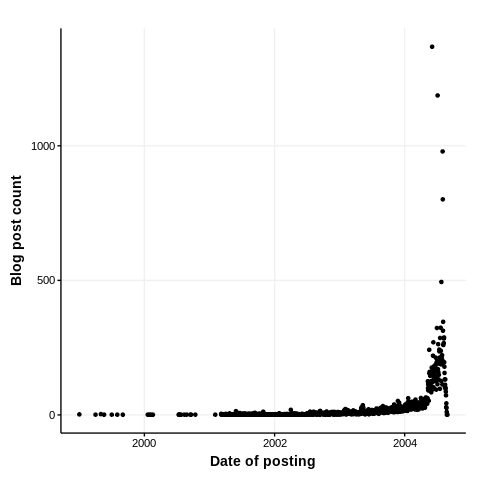

In [ ]:
%%R

qplot(as.Date(messages.byDate$date), messages.byDate$message_count) +
theme_Publication() +
ylab("Blog post count") + xlab("Date of posting")

**Figure S1.** Date of blog posts.

Some additional statistics for your reporting if you write this up: total messages, min and max dates.

In [ ]:
%%R

sum(messages.byDate$message_count)

[1] 33134


In [ ]:
%%R

min(as.Date(messages.byDate$date))

[1] "1999-01-01"


In [ ]:
%%R

max(as.Date(messages.byDate$date))

[1] "2004-08-28"


#### ✍ for your methods section:
"Users wrote 33,136 posts betwen January 1st, 1999 and the 28th of August, 2004. See Figure S1 for posting frequency across dates."

## 10) Plot messages per user (histogram) <a class="anchor" id="plot_msgs_user"></a>

In [ ]:
%%R

messages.byGroup <- dbGetQuery(
    db_con,
    "SELECT COUNT(*) AS message_count, user_id FROM tt7_msgs_n962 GROUP BY user_id;")

let's look at that.

In [ ]:
%R messages.byGroup

,message_count,user_id
1,7,11253
2,166,47519
3,967,105748
4,51,118791
5,421,171019
...,...,...
958,5,4313749
959,5,4314676
960,2,4316235
961,3,4317978


Let's plot this!

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.




(`geom_bar()`). 



In addition: Warning message:
`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing` 


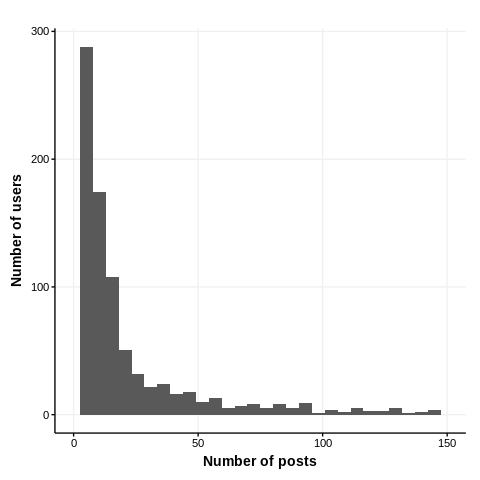

In [ ]:
%%R

qplot(messages.byGroup$message_count) +
theme_Publication() +
ylab("Number of users") +
xlab("Number of posts") +
xlim(0,150)

**Figure S2.** Histogram of blog posts per user

Additional statistics for your methods section:

In [ ]:
%R describe(messages.byGroup)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
message_count,1,962.0,3.444283e+01,95.766427,10.0,1.582857e+01,10.3782,1.0,1308.0,1307.0,7.887225,77.757662,3.087634
user_id,2,962.0,3.396123e+06,908055.626146,3659691.5,3.576556e+06,493857.0252,11253.0,4333855.0,4322602.0,-1.762439,2.522513,29276.888421


#### ✍  for your methods section:

"Users wrote an average of 34 (SD = 96, min = 1, max = 1,308) blog posts."

## 11) Plot words per user <a class="anchor" id="plot_words"></a>

In [ ]:
%%sql

PRAGMA table_info(outcomes_meta_n962);

Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

cid,name,type,notnull,dflt_value,pk
0,user_id,INT,0,None,0
1,gender,TEXT,0,None,0
2,age,INT,0,None,0
3,occu,TEXT,0,None,0
4,sign,TEXT,0,None,0
5,is_female,INT,0,None,0
6,_avg1gramLength,REAL,0,None,0
7,_avg1gramsPerMsg,REAL,0,None,0
8,_total1grams,REAL,0,None,0
9,_totalMsgs,REAL,0,None,0


In [ ]:
%%R

words.byGroup <- dbGetQuery(db_con, "SELECT user_id, _total1grams AS wordCount FROM outcomes_meta_n962")
describe(words.byGroup$wordCount)

   vars   n    mean       sd median trimmed    mad min    max  range  skew
X1    1 962 8845.57 23973.17   2647 4256.69 2692.4 503 492270 491767 10.73
   kurtosis     se
X1    180.4 772.93


In [ ]:
%%R

sum(words.byGroup$wordCount)

[1] 8509434


#### ✍ for your methods section:

"Users wrote an average of 8,845 words (SD = 23,973) for a total of 8,509,434 words."

Let's plot a histogram! Sweet sweet qplot.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.




(`geom_bar()`). 



In addition: Warning message:
`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing` 


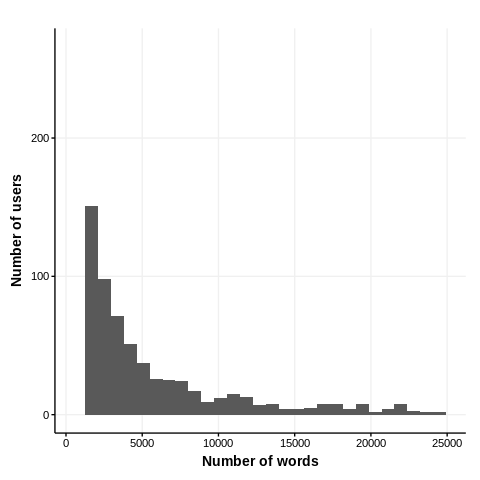

In [ ]:
%%R

qplot(words.byGroup$wordCount) +
theme_Publication() +
ylab("Number of users") +
xlab("Number of words") +
xlim(500, 25000)

**Figure S3.** Histogram of words per user. Only users with more than 500 words were retained in the study dataset.

## 12) Sample descriptives from outcome table <a class="anchor" id="sample_desc"></a>

Let's explore the outcome table by producing a nice apaTable of the outcome variables

In [ ]:
%%R

outcomes <- dbGetQuery(db_con, "SELECT * FROM outcomes_meta_n962")

apa.cor.table(outcomes[c("age", "occu", "is_female", "_total1grams", "_totalMsgs")], filename = "sample_descriptives.doc")



Means, standard deviations, and correlations with confidence intervals
 

  Variable        M       SD       1           2           3         
  1. age          23.31   8.03                                       
                                                                     
  2. is_female    0.50    0.50     -.04                              
                                   [-.11, .02]                       
                                                                     
  3. _total1grams 8845.57 23973.17 .02         .01                   
                                   [-.05, .08] [-.05, .08]           
                                                                     
  4. _totalMsgs   34.44   95.77    .02         .03         .84**     
                                   [-.05, .08] [-.03, .09] [.82, .86]
                                                                     

Note. M and SD are used to represent mean and standard deviation, respectively.
Val

Note that this has outputted a word file `sample_descriptives.doc` which you can download with on the left with nicely formatted tables.


As another example, let's report mean levels based on gender. You could imagine reporting these separately for the group vs. control group you are analyzing, etc.

In [ ]:
%%R

describeBy(outcomes[c("age", "occu", "is_female", "_total1grams", "_totalMsgs")], group = "is_female")


 Descriptive statistics by group 
is_female: 0
             vars   n    mean       sd median trimmed     mad min    max  range
age             1 482   23.65     8.01   24.0   22.77   10.38  13     48     35
occu            2 482   23.80    10.22   20.0   24.50   13.34   1     39     38
is_female       3 482    0.00     0.00    0.0    0.00    0.00   0      0      0
_total1grams    4 482 8541.28 27490.82 2581.5 4084.29 2659.78 506 492270 491764
_totalMsgs      5 482   31.63    91.32   10.0   15.22   10.38   1   1308   1307
              skew kurtosis      se
age           0.86     0.24    0.36
occu         -0.25    -1.04    0.47
is_female      NaN      NaN    0.00
_total1grams 12.48   201.29 1252.17
_totalMsgs    9.26   108.02    4.16
------------------------------------------------------------ 
is_female: 1
             vars   n    mean       sd median trimmed     mad min    max  range
age             1 480   22.96     8.04   23.0   21.88    8.90  13     48     35
occu            2 480

## 13) Lexicon feature extraction <a class="anchor" id="lex_xtract"></a>

Now that we have extracted the 1grams above, we'll extract features for the lexica we imported above -- just to double check that everything works with our custom lexicon we have so laboriously imported. To point to the database containing the lexica (in our case, the tutorial_07 database), we use the `--lexicondb <database>` flag.

In [ ]:
database = "tutorial_07"
msgs_table = 'tt7_msgs'
# Note: tt7_lexica is the name of the TABLE that contains your lexicon in your database, with its dictionary categories.

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field user_id \
    --lexicondb {database} \
    --add_lex_table -l tt7_lexica



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2025-05-01 05:08:21
-----
Connecting to SQLite database: /content/sqlite_data/tutorial_07
###################################################################
  specify --weighted_lexicon so the weights won't be used
###################################################################
query: PRAGMA table_info(tt7_msgs)
SQL Query: DROP TABLE IF EXISTS feat$cat_tt7_lexica$tt7_msgs$user_id$1gra
SQL Query: CREATE TABLE feat$cat_tt7_lexica$tt7_msgs$user_id$1gra ( id INTEGER PRIMARY KEY, group_id INTEGER, feat VARCHAR(10), value INTEGER, group_norm DOUBLE)


Creating index correl_field on table:feat$cat_tt7_lexica$tt7_msgs$user_id$1gra, column:group_id 


SQL Query: CREATE INDEX correl_field$cat_tt7_lexica$tt7_msgs$user_id$1gra ON feat$cat_tt7_lexica$tt7_msgs$user_id$1gra (group_id)


Creating index feature on table:feat$cat_tt7_lexica$tt7_msgs$user_id$1gra, column:feat 


SQL Query: C

## 14) Custom lexicon correlation and unpacking <a class="anchor" id="lex_correl"></a>

Let's correlate our custom lexicon, and then unpack which words drives its correlation.

Let's correlate it against `age`. We'll also consider with users with at least 500 words using the `--group_freq_thresh 500` flag.

In [ ]:
database = "tutorial_07"
lexicondb = "tutorial_07"
msgs_table = 'tt7_msgs'
outcomes_table = 'tt7_outcomes'
feat_tt7_lexica_user = 'feat$cat_tt7_lexica$tt7_msgs$user_id$1gra'

OUTPUT_FOLDER = './outputs_tutorial_07'
OUTPUT_NAME = 'tt7_lexica_age'
!mkdir -p {OUTPUT_FOLDER}

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field user_id \
    --group_freq_thresh 500 \
    --correlate --csv \
    --feat_table '{feat_tt7_lexica_user}' \
    --outcome_table {outcomes_table} \
    --lexicondb {lexicondb} \
    --outcomes age \
    --output_name {OUTPUT_FOLDER}/{OUTPUT_NAME}



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2025-05-01 05:08:46
-----
Connecting to SQLite database: /content/sqlite_data/tutorial_07
Connecting to SQLite database: /content/sqlite_data/tutorial_07
Loading Outcomes and Getting Groups for: {'age'}
Connecting to SQLite database: /content/sqlite_data/tutorial_07
Yielding data over ['age'], adjusting for: [].
Yielding norms with zeros (962 groups * 4 feats).
/usr/local/lib/python3.11/dist-packages/dlatk/outcomeAnalyzer.py:733: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  else: tup = pearsonr(dataList, outcomeList) + (len(dataList),)
Namespace(lexinterface=False, toinitfile=None, frominitfile='', mysqlconfigfile='', dbengine='sqlite', corpdb='tutorial_07', corptable='tt7_msgs', correl_field='user_id', message_field='message', messageid_field='message_id', date_field='updated_time', lexicondb='tutorial_07', encoding='utf8mb4',

This throws out only the CSV (and not the HTML) with the correlation in the `./outputs_tutorial_07` folder, as shown in your file browser on the left!

### 14a) Unpacking

We then unpack the correlation by looking at the words driving the correlation. We make use of the `--whitelist` flag here. Don't forget the `--lexicondb` flag here.

In [ ]:
database = "tutorial_07"
lexicondb = "tutorial_07"
msgs_table = 'tt7_msgs'
outcomes_table = 'tt7_outcomes'
feat_1gram_user = 'feat$1gram$tt7_msgs$user_id'

OUTPUT_FOLDER = './outputs_tutorial_07'
OUTPUT_NAME = '1gram_age_FILTER_tt7_lexica'
!mkdir -p {OUTPUT_FOLDER}

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field user_id \
    --correlate --csv \
    --feat_table '{feat_1gram_user}' \
    --outcome_table {outcomes_table} \
    --outcomes age \
    --lexicondb {lexicondb} \
    --whitelist --categories POSEMO --lex_table tt7_lexica \
    --output_name {OUTPUT_FOLDER}/{OUTPUT_NAME} > {OUTPUT_FOLDER}/logs.text 2>&1

(Because of the `2>&1`, it's quiet and doesn't give you all the cell output.)

The command gives us a CSV with the most frequent words for the correlated dictionary. Something like this, with a modicum of excel filtering.

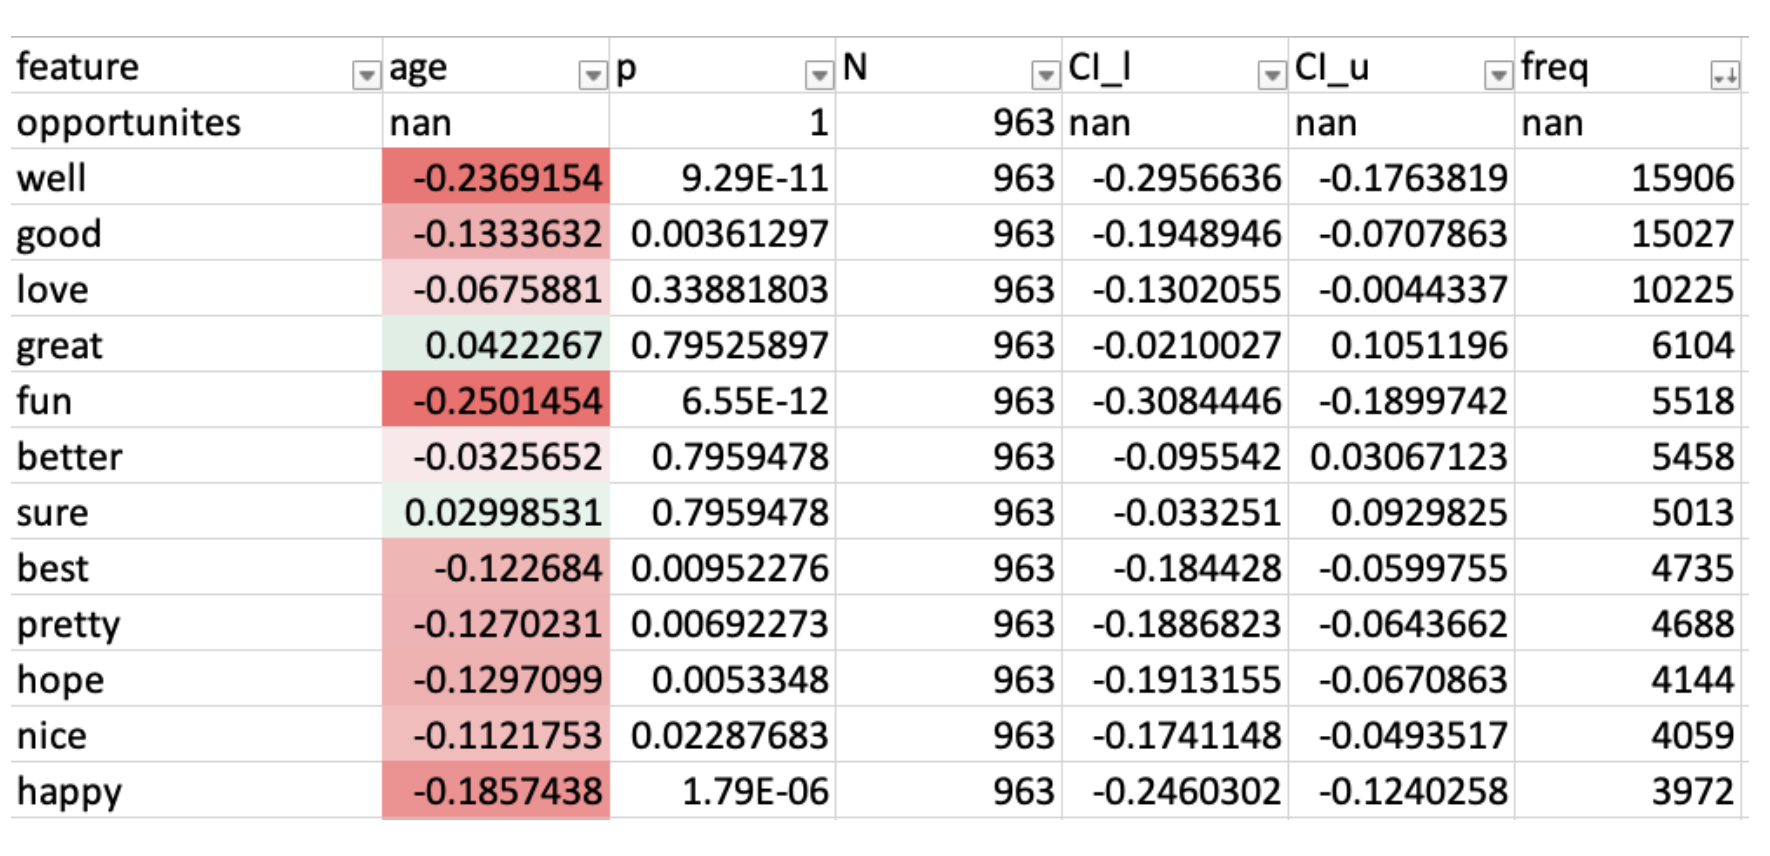

## 15) Language filtering and cleaning message table

There are time when your dataset (message table) contains text in different languages, and you want to focus your analysis on a single language, say English. Then before you do any kind of feature extraction (where relative frequencies are calculated) you need to filter the text into the particular. DLATK provides `--language_filter` flag to do this.

We usually use this with another flag `--clean_messages` which removes URLs and @-mentions in the dataset, thus de-identifying any humans (if) mentioned in a message.

To demonstrate these flags, let's filter our `tt7_msgs` table to contain only English messages.

Takes about 3 minutes! 🙂

In [ ]:
database = "tutorial_07"
msgs_table = 'tt7_msgs'

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field message_id \
    --language_filter en --clean_messages



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2025-05-01 05:11:13
-----
Connecting to SQLite database: /content/sqlite_data/tutorial_07
SQL Query: DROP TABLE IF EXISTS tt7_msgs_en
SQL Query: CREATE TABLE `tt7_msgs_en` (
  `user_id` INTEGER,
  `created_date` TEXT,
  `message` TEXT,
  `message_id` INTEGER
)
Reading 33,278 messages
   10000 rows written (30.149 % done)
   20000 rows written (60.358 % done)
   30000 rows written (90.555 % done)
Adding final rows
Kept 33130 out of 33278 messages
{'tt7_msgs_en': 33130}
-------
Settings:

Database - tutorial_07
Corpus - tt7_msgs
Group ID - message_id
-------
Interface Runtime: 154.23 seconds
DLATK exits with success! A good day indeed  ¯\_(ツ)_/¯.


This creates a new table called `tt7_msgs_en` which contains only English text.

Another step that we usually follow with this is to remove duplicate messages using `--deduplicate`. This flag removes messages which contains the same first 6 tokens as another message in the same group. And that means the `--correl_field` cannot be `message_id` since it's not possible to have two messages with same `message_id`s.

In [ ]:
database = "tutorial_07"
msgs_table = 'tt7_msgs_en'

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field user_id \
    --deduplicate



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2025-05-01 05:14:24
-----
Connecting to SQLite database: /content/sqlite_data/tutorial_07
SQL Query: DROP TABLE IF EXISTS tt7_msgs_en_dedup
SQL Query: CREATE TABLE `tt7_msgs_en_dedup` (
  `user_id` INTEGER,
  `created_date` TEXT,
  `message` TEXT,
  `message_id` INTEGER
)
deduplicating messages for 999 'user_id's
500 deduplicated users inserted!
-------
Settings:

Database - tutorial_07
Corpus - tt7_msgs_en
Group ID - user_id
-------
Interface Runtime: 90.93 seconds
DLATK exits with success! A good day indeed  ¯\_(ツ)_/¯.


## 16) Sentence tokenization in DLATK <a class="anchor" id="sent_tok"></a>

DLATK provides a convenient flag `--add_sent_per_row` which tokenizes the messages into individual sentences and stores them as a list per message. Let's try this on the message table `tt7_msgs` we stored earlier. But since we want to tokenize in message level, the `--correl_field` would be the `message_id`.

In [ ]:
database = "tutorial_07"
msgs_table = 'tt7_msgs'

To do sentence tokenization, DLATK requires you to have the following package from NLTK downloading!

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field user_id \
    --add_sent_per_row



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2025-05-01 05:16:56
-----
Connecting to SQLite database: /content/sqlite_data/tutorial_07
SQL Query: DROP TABLE IF EXISTS tt7_msgs_sent
SQL Query: CREATE TABLE tt7_msgs_sent ( user_id INTEGER, created_date TEXT, message TEXT, message_id VARCHAR(128))


Creating index message_id on table:tt7_msgs_sent, column:message_id 


SQL Query: CREATE INDEX message_idmsgs_sent ON tt7_msgs_sent (message_id)
finding messages for 1000 'user_id's
-------
Settings:

Database - tutorial_07
Corpus - tt7_msgs
Group ID - user_id
-------
Interface Runtime: 24.02 seconds
DLATK exits with success! A good day indeed  ¯\_(ツ)_/¯.


Above command created a new sentence level table called `tt7_msgs_sent` as shown below.

In [ ]:
%%sql

SELECT *
FROM tt7_msgs_sent
ORDER BY RANDOM()
LIMIT 5;

Running query in 'sqlite:///sqlite_data/tutorial_07.db?charset=utf8mb4'

user_id,created_date,message,message_id
1756743,2004-02-17,I think it is nice that this show was put together for little people.,630_04
3430461,2004-05-23,I'm 16 years old and I go to Great Baddow Hiâ¦ Sports College.,21328_07
1266795,2004-05-20,(First time EVER!),9960_06
891211,2004-06-27,nice vivid colors though.,22493_02
3347922,2004-06-28,Finally finally the one whose presence sticks out the most.,3745_37


You can use this new message table for topic modeling and everywhere else you would use the original message table. Remember, if you extract (`--correl_field`) at the `user_id` level, all messages for that group_id will be combined by DLATK, so it doesn't matter which of the two kinds of message tables (original or sentence-tokenized) you specify.

If you made it this far, congratulations! 🎉🎉🥳🤓

## ‼️ **Save your database and/or output files** ‼️

Let's save all this work into as a new database file in your GDrive `sqlite_databases` folder!

In [ ]:
database = 'tutorial_07'

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# copy the database file to your Drive
!cp -f "sqlite_data/{database}.db" "/content/drive/MyDrive/sqlite_databases/"

print(f"✅ Database '{database}.db' has been copied to your Google Drive.")

Mounted at /content/drive
✅ Database 'tutorial_07.db' has been copied to your Google Drive.


We generated a lot of output in this tutorial! Here's how you can save it to your Drive if you want to!

In [ ]:
OUTPUT_FOLDER = './outputs_tutorial_07'

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Copy the database file to your Drive (-r makes it copy the folder and all files/folders inside)
!cp -f -r {OUTPUT_FOLDER} "/content/drive/MyDrive/"

print(f"✅ '{OUTPUT_FOLDER}' has been copied to your Google Drive.")

Mounted at /content/drive
✅ './outputs_tutorial_07' has been copied to your Google Drive.


*Also*, you can save a copy of `psych290RcodeV1.R` to your Drive with this!

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Copy the database file to your Drive (-r makes it copy the folder and all files/folders inside)
!cp -f "./psych290_data/helper_files/psych290RcodeV1.R" "/content/drive/MyDrive/"

print(f"✅ psych290RcodeV1.R has been copied to your Google Drive.")